In [4]:
# Useful functions to use:
# skimage.draw.line_nd
# numpy.convolve
# jpg i dicom
#TODO przetwarzanie obrazu stożkowo, 90-270 na 4    50%
#TODO 90-720 x, miary zgodności y
#TODO filtrowanie

In [13]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt

In [14]:
def loadImage(filename):
    image = ski.io.imread(filename)
    image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

def saveImage(image, filename):
    data = (image * 255).astype(np.uint8)
    ski.io.imsave(filename, data)

def showImage(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [7]:
import pydicom

# Use this file as a wireframe while constructing a new DICOM file
REFERENCE_DICOM = 'dicom/Kolo.dcm'
def loadDicom(filename):
    ds = pydicom.dcmread(filename)
    imageData = ds.pixel_array
    image = imageData / np.max(imageData)

    patName = ds.PatientName
    displayName = patName.given_name + " " + patName.family_name
    comment = ds.ImageComments
    acquisitionDate = ds.get('AcquisitionDate', None)

    metadata = (displayName, comment, acquisitionDate)
    return image, metadata

def saveDicom(filename, image, metadata):
    imageData = (image * 255).astype(np.uint8)

    ds = pydicom.dcmread(REFERENCE_DICOM)
    ds.PixelData = imageData.tobytes()
    ds.Rows, ds.Columns = imageData.shape

    patName = metadata[0].split(' ', maxsplit=1)
    ds.PatientName = patName[1] + '^' + patName[0]
    ds.ImageComments = metadata[1]
    ds.AcquisitionDate = metadata[2]
    ds.save_as(filename, write_like_original=False)


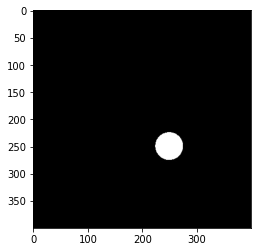

In [8]:
image = loadImage('images/Kropka.jpg')
showImage(image)

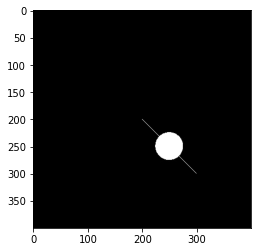

In [9]:
l = ski.draw.line_nd((200, 200), (300, 300))
image[l] = 1
showImage(image)
saveImage(image, 'Kropka.png')

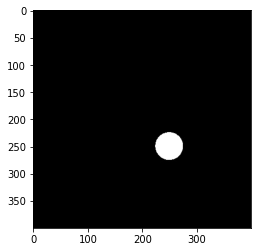

('John Doe', 'what a lovely image we have here...', None)


In [10]:
dicomImage, metadata = loadDicom('dicom/Kropka.dcm')
showImage(dicomImage)
print(metadata)

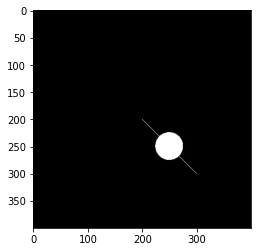

In [11]:
l = ski.draw.line_nd((200, 200), (300, 300))
dicomImage[l] = 1
showImage(dicomImage)
saveDicom('Kropka.dcm', dicomImage, (metadata[0], 'Kropka', '20230304'))

# Image processing
### Radon transformation

In [ ]:
# doesnt work, see next code box

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.constants import golden_ratio
from scipy.fft import fft, ifft, fftfreq, fftshift
from warnings import warn
from functools import partial

def radon_transform(image):
    if theta is None:
        theta = np.arange(180)

    image = convert_to_float(image, preserve_range)

    if circle:
        shape_min = min(image.shape)
        radius = shape_min // 2
        img_shape = np.array(image.shape)
        coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]], dtype=object)
        dist = ((coords - img_shape // 2) ** 2).sum(0)
        # Crop image to make it square
        slices = tuple(slice(int(np.ceil(excess / 2)), int(np.ceil(excess / 2) + shape_min))
        if excess > 0 else slice(None)
        for excess in (img_shape - shape_min))
        padded_image = image[slices]
    else:
        diagonal = np.sqrt(2) * max(image.shape)
        pad = [int(np.ceil(diagonal - s)) for s in image.shape]
        new_center = [(s + p) // 2 for s, p in zip(image.shape, pad)]
        old_center = [s // 2 for s in image.shape]
        pad_before = [nc - oc for oc, nc in zip(old_center, new_center)]
        pad_width = [(pb, p - pb) for pb, p in zip(pad_before, pad)]
        padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)

    # padded_image is always square
    center = padded_image.shape[0] // 2
    radon_image = np.zeros((padded_image.shape[0], len(theta)), dtype=image.dtype)

    for i, angle in enumerate(np.deg2rad(theta)):
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        R = np.array([[cos_a, sin_a, -center * (cos_a + sin_a - 1)],
            [-sin_a, cos_a, -center * (cos_a - sin_a - 1)],
            [0, 0, 1]])
        rotated = warp(padded_image, R, clip=False)
        radon_image[:, i] = rotated.sum(0)
    return radon_image



radon_transform(image)

[[1.2246467991473532e-14, -3.4904812874566953, -6.979899340500191, -10.467191248588769, -13.951294748825067, -17.431148549531645, -20.90569265353071, -24.373868681029474, -27.83462019201307, -31.286893008046164, -34.72963553338606, -38.16179907530896, -41.58233816355187, -44.990210868773005, -48.384379119933556, -51.76380902050417, -55.12747116339981, -58.47434094454733, -61.80339887498947, -65.11363089143133, -68.40402866513374, -71.67358990906006, -74.92131868318242, -78.14622569785476, -81.34732861516005, -84.52365234813986, -87.6742293578155, -90.79809994790935, -93.89431255717818, -96.9619240492674, -99.99999999999996, -103.00761498201085, -105.98385284664096, -108.92780700300541, -111.83858069414934, -114.71528727020923, -117.5570504584946, -120.36300463040968, -123.13229506513166, -125.86407820996746, -128.55752193730788, -131.21180579810144, -133.82612127177165, -136.39967201249968, -138.93167409179947, -141.42135623730948, -143.86796006773025, -146.2707403238341, -148.62896509

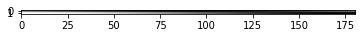

In [21]:
import math

#coords = np.array(image.shape[0], image.shape[1]) #1-400 array
#x, y = image.shape[0], image.shape[1]

n = 90 							# not sure
r = 200 						# not sure
plot = [[],[]]
for alpha in range(90, 271):
	radiansAlpha = math.radians(alpha)
	xE = r * math.cos(radiansAlpha)
	yE = r * math.sin(radiansAlpha)
	for i in range(n):
		fi = 90/n  				# not sure
		xD = r * math.cos(radiansAlpha + math.pi + fi/2 + i*fi/(n-1))
		yD = r * math.sin(radiansAlpha + math.pi + fi/2 + i*fi/(n-1))
	plot[0].append(xE)
	plot[1].append(yE)
		
print(plot)
showImage(plot)
